In [1]:
# Imports principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import xgboost as xgb

# Procesamiento de texto
import nltk
from nltk.corpus import stopwords
from collections import Counter
import joblib

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")

print("✅ Librerías importadas exitosamente")

✅ Librerías importadas exitosamente


In [2]:
# Cargar el dataset
file_path = "datasets\health_prescription_data.csv"

# Leer con delimitador correcto
df = pd.read_csv(file_path, delimiter=';')

print(f"📊 Dataset cargado: {df.shape}")
print(f"🔍 Columnas: {df.columns.tolist()}")
print(f"\n📋 Información del dataset:")
print(df.info())

# Mostrar primeras filas
print(f"\n👀 Primeras 3 filas:")
df.head(3)

📊 Dataset cargado: (744, 7)
🔍 Columnas: ['SUBJECT_ID', 'ROW_ID', 'HADM_ID', 'CATEGORY', 'ADMISSION_TYPE', 'DIAGNOSIS', 'TEXT']

📋 Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   SUBJECT_ID      744 non-null    int64 
 1   ROW_ID          744 non-null    int64 
 2   HADM_ID         744 non-null    int64 
 3   CATEGORY        744 non-null    object
 4   ADMISSION_TYPE  744 non-null    object
 5   DIAGNOSIS       744 non-null    object
 6   TEXT            744 non-null    object
dtypes: int64(3), object(4)
memory usage: 40.8+ KB
None

👀 Primeras 3 filas:


,SUBJECT_ID,ROW_ID,HADM_ID,CATEGORY,ADMISSION_TYPE,DIAGNOSIS,TEXT
0,26880,178,135453,Discharge summary,EMERGENCY,S/P FALL;TELEMETRY,Admission Date: [**2162-3-3**] D...
1,42130,181,114236,Discharge summary,ELECTIVE,LEFT SPHENOID MENENGIOMA/SDA,Admission Date: [**2150-2-25**] ...
2,76874,212,113329,Discharge summary,EMERGENCY,TYLENOL BENZO OVERDOSE,Admission Date: [**2101-10-25**] ...


❓ Datos faltantes por columna:
SUBJECT_ID        0
ROW_ID            0
HADM_ID           0
CATEGORY          0
ADMISSION_TYPE    0
DIAGNOSIS         0
TEXT              0
dtype: int64

📂 Distribución de CATEGORY:
CATEGORY
Discharge summary    744
Name: count, dtype: int64

🏥 Distribución de ADMISSION_TYPE:
ADMISSION_TYPE
EMERGENCY    632
ELECTIVE     105
URGENT         7
Name: count, dtype: int64


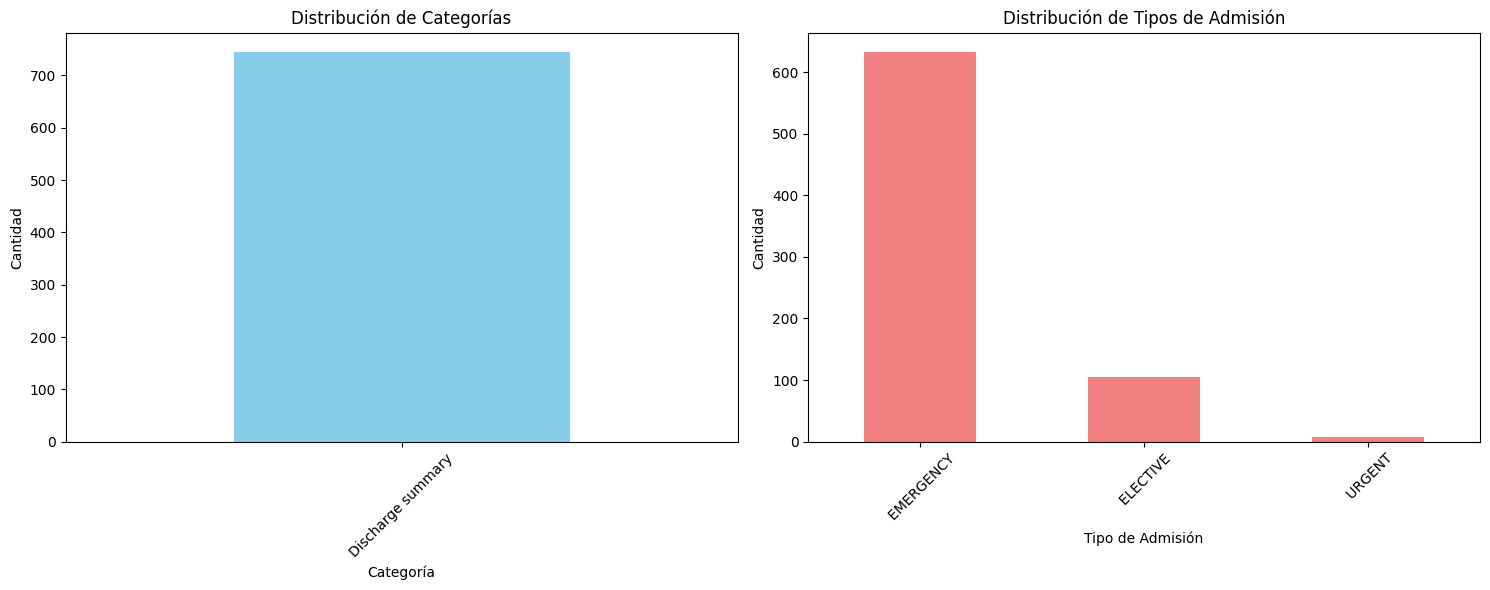

In [3]:
# Análisis de datos faltantes
print("❓ Datos faltantes por columna:")
missing_data = df.isnull().sum()
print(missing_data)

# Distribución de categorías
print(f"\n📂 Distribución de CATEGORY:")
category_counts = df['CATEGORY'].value_counts()
print(category_counts)

# Distribución de tipos de admisión
print(f"\n🏥 Distribución de ADMISSION_TYPE:")
admission_counts = df['ADMISSION_TYPE'].value_counts()
print(admission_counts)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de categorías
category_counts.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Distribución de Categorías')
axes[0].set_xlabel('Categoría')
axes[0].set_ylabel('Cantidad')
axes[0].tick_params(axis='x', rotation=45)

# Gráfico de tipos de admisión
admission_counts.plot(kind='bar', ax=axes[1], color='lightcoral')
axes[1].set_title('Distribución de Tipos de Admisión')
axes[1].set_xlabel('Tipo de Admisión')
axes[1].set_ylabel('Cantidad')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [4]:
# Limpiar datos
print("🧹 Limpiando datos...")

# Eliminar filas con datos faltantes críticos
df_clean = df.dropna(subset=['TEXT', 'DIAGNOSIS']).copy()

# Convertir a string
df_clean['TEXT'] = df_clean['TEXT'].astype(str)
df_clean['DIAGNOSIS'] = df_clean['DIAGNOSIS'].astype(str)

# Filtrar textos muy cortos (menos de 50 caracteres)
df_clean = df_clean[df_clean['TEXT'].str.len() > 50]

print(f"📊 Datos después de limpieza: {df_clean.shape}")
print(f"🗑️ Registros eliminados: {len(df) - len(df_clean)}")

# Mostrar ejemplo de texto
print(f"\n📝 Ejemplo de texto médico:")
print(f"Texto: {df_clean.iloc[0]['TEXT'][:300]}...")
print(f"Diagnóstico: {df_clean.iloc[0]['DIAGNOSIS']}")

🧹 Limpiando datos...
📊 Datos después de limpieza: (744, 7)
🗑️ Registros eliminados: 0

📝 Ejemplo de texto médico:
Texto: Admission Date:  [**2162-3-3**]              Discharge Date:   [**2162-3-25**]

Date of Birth:  [**2080-1-4**]             Sex:   M

Service: MEDICINE

Allergies:
Patient recorded as having No Known Allergies to Drugs

Attending:[**First Name3 (LF) 1828**]
Chief Complaint:
Mr. [**Known lastname 1829...
Diagnóstico:  S/P FALL;TELEMETRY


In [5]:
class SymptomExtractor:
    """Extractor de síntomas de textos médicos"""
    
    def __init__(self):
        # Patrones para extraer síntomas
        self.symptoms_patterns = [
            r'chief complaint[:\s]*([^.]+)',
            r'presents?\s+with\s+([^.]+)',
            r'history of present illness[:\s]*([^.]+?)(?:past medical|social|family|review)',
            r'complain(?:ing|s)?\s+of\s+([^.]+)',
            r'symptoms?\s+(?:include|of)[:\s]*([^.]+)',
            r'patient\s+(?:reports?|states?|denies?)\s+([^.]+)',
            r'experiencing\s+([^.]+)',
            r'(\w+\s+pain)',
            r'(shortness of breath|sob|dyspnea)',
            r'(nausea|vomiting|fever|chills|headache|dizziness)',
            r'(cough|fatigue|weakness|malaise|chest pain)',
            r'(abdominal pain|back pain|joint pain)',
            r'(difficulty breathing|trouble breathing)',
            r'(loss of consciousness|confusion|altered mental status)'
        ]
        
        # Palabras clave médicas importantes
        self.medical_keywords = [
            'pain', 'ache', 'discomfort', 'pressure', 'burning',
            'nausea', 'vomiting', 'fever', 'chills', 'sweating',
            'shortness', 'difficulty', 'trouble', 'unable',
            'weakness', 'fatigue', 'tired', 'exhausted',
            'dizziness', 'lightheaded', 'confusion', 'headache',
            'cough', 'congestion', 'runny', 'sore throat',
            'swelling', 'inflammation', 'redness', 'itching'
        ]
    
    def extract_symptoms(self, text):
        """Extraer síntomas del texto médico"""
        text_lower = text.lower()
        extracted_symptoms = []
        
        # Buscar patrones específicos
        for pattern in self.symptoms_patterns:
            matches = re.findall(pattern, text_lower, re.IGNORECASE | re.DOTALL)
            for match in matches:
                if isinstance(match, tuple):
                    match = ' '.join(match)
                
                # Limpiar y procesar
                symptom = self.clean_symptom_text(match)
                if symptom and len(symptom) > 3:
                    extracted_symptoms.append(symptom)
        
        # Buscar palabras clave médicas en contexto
        for keyword in self.medical_keywords:
            if keyword in text_lower:
                # Extraer contexto alrededor de la palabra clave
                context_pattern = rf'.{{0,30}}{keyword}.{{0,30}}'
                contexts = re.findall(context_pattern, text_lower)
                for context in contexts:
                    clean_context = self.clean_symptom_text(context)
                    if clean_context and len(clean_context) > 5:
                        extracted_symptoms.append(clean_context)
        
        # Combinar y limpiar síntomas únicos
        unique_symptoms = list(set(extracted_symptoms))
        
        # Tomar los más relevantes (máximo 5)
        final_symptoms = unique_symptoms[:5]
        
        return ' '.join(final_symptoms)
    
    def clean_symptom_text(self, text):
        """Limpiar texto de síntomas"""
        if not text:
            return ""
        
        text = str(text).lower().strip()
        
        # Remover patrones no deseados
        unwanted_patterns = [
            r'\[\*\*[^\]]+\*\*\]',  # [**data**]
            r'\d{1,2}[-/]\d{1,2}[-/]\d{2,4}',  # fechas
            r'\d+:\d+',  # horas
            r'patient|pt\.|the patient',  # referencias al paciente
            r'dr\.|doctor|physician|md',  # referencias médicas
            r'admission|discharge|hospital|unit|floor',  # términos hospitalarios
            r'history|past|previous|prior',  # términos temporales
        ]
        
        for pattern in unwanted_patterns:
            text = re.sub(pattern, ' ', text)
        
        # Limpiar caracteres especiales
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        
        return text.strip()

# Aplicar extractor
extractor = SymptomExtractor()

print("🔍 Extrayendo síntomas de textos médicos...")
df_clean['extracted_symptoms'] = df_clean['TEXT'].apply(extractor.extract_symptoms)

# Filtrar registros con síntomas significativos
df_clean = df_clean[df_clean['extracted_symptoms'].str.len() > 20]

print(f"✅ Síntomas extraídos. Registros válidos: {len(df_clean)}")

# Mostrar ejemplos
print(f"\n📋 Ejemplos de síntomas extraídos:")
for i in range(min(3, len(df_clean))):
    print(f"\n{i+1}. Síntomas: {df_clean.iloc[i]['extracted_symptoms'][:150]}...")
    print(f"   Diagnóstico: {df_clean.iloc[i]['DIAGNOSIS']}")

🔍 Extrayendo síntomas de textos médicos...
✅ Síntomas extraídos. Registros válidos: 740

📋 Ejemplos de síntomas extraídos:

1. Síntomas: was placed after had difficulty for pain as needed for pain and olanzapine as needed for swelling question foreign body anteri control pain...
   Diagnóstico:  S/P FALL;TELEMETRY

2. Síntomas: your pain headache at the wound site increasing redness does not have headache nausea vomiting confusion...
   Diagnóstico:  LEFT SPHENOID MENENGIOMA/SDA

3. Síntomas: od of benzodiazepine and tylenol medicaion overdose an attempt to suicide xanax tylenol klonopin overdose major surgical or invasive procedure none of...
   Diagnóstico:  TYLENOL BENZO OVERDOSE


🏷️ Normalizando diagnósticos...
✅ Diagnósticos normalizados. Categorías únicas: 265

📊 Top 10 Diagnósticos más frecuentes:
  Cardiovascular: 102 casos
  Gastrointestinal: 65 casos
  Infection: 54 casos
  Central Nervous System/ Neuromuscular: 44 casos
  Pneumonia: 43 casos
  Respiratory: 26 casos
  Musculoskeletal: 23 casos
  Diabetes: 18 casos
  Lower Gi Bleed: 17 casos
  Upper Gi Bleed: 14 casos


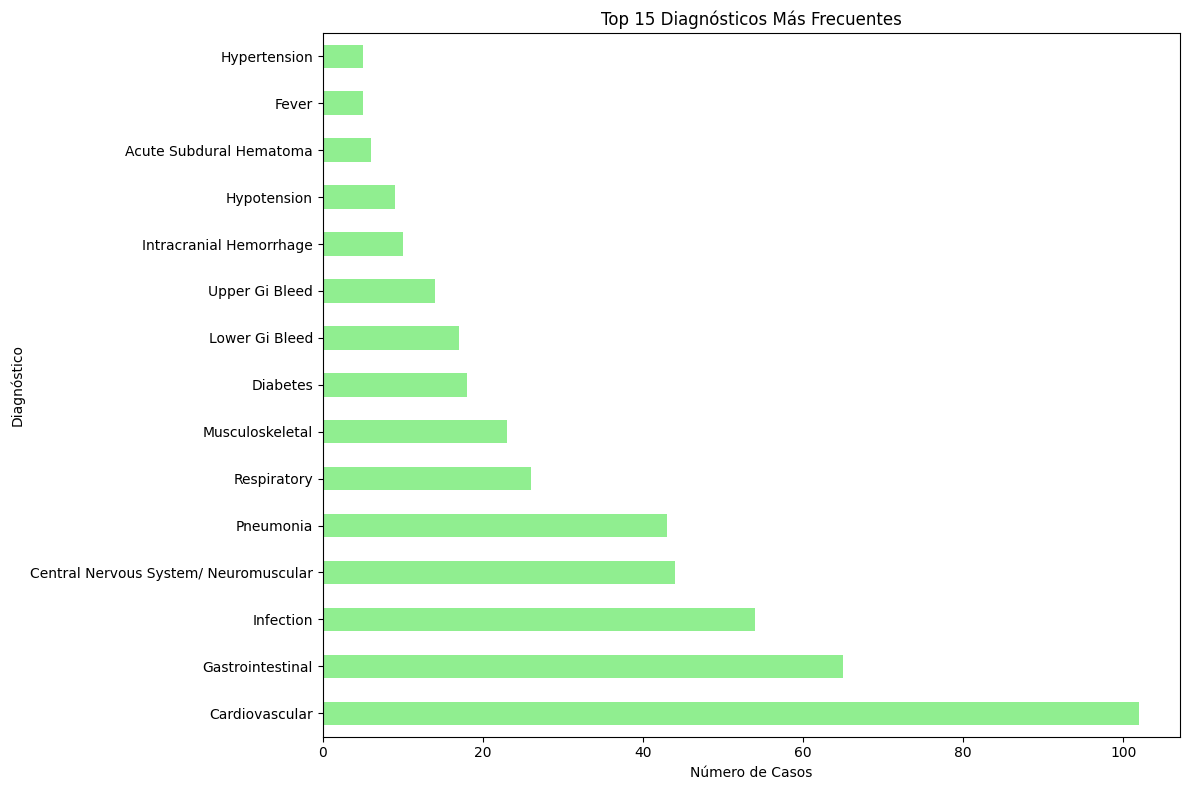

In [6]:
class DiagnosisNormalizer:
    """Normalizador de diagnósticos médicos"""
    
    def __init__(self):
        self.diagnosis_mapping = {
            # Cardiovasculares
            'heart': 'Cardiovascular',
            'cardiac': 'Cardiovascular', 
            'coronary': 'Cardiovascular',
            'hypertension': 'Hypertension',
            'hypertensive': 'Hypertension',
            'myocardial': 'Cardiovascular',
            'atrial fibrillation': 'Cardiovascular',
            'chest pain': 'Cardiovascular',
            'angina': 'Cardiovascular',
            
            # Respiratorias
            'pneumonia': 'Pneumonia',
            'respiratory': 'Respiratory',
            'asthma': 'Asthma',
            'copd': 'Respiratory',
            'bronchitis': 'Bronchitis',
            'pulmonary': 'Respiratory',
            'lung': 'Respiratory',
            'breathing': 'Respiratory',
            'dyspnea': 'Respiratory',
            
            # Neurológicas
            'stroke': 'Central Nervous System/ Neuromuscular',
            'neurological': 'Central Nervous System/ Neuromuscular',
            'seizure': 'Central Nervous System/ Neuromuscular',
            'migraine': 'Migraine',
            'headache': 'Migraine',
            'confusion': 'Central Nervous System/ Neuromuscular',
            'altered mental': 'Central Nervous System/ Neuromuscular',
            
            # Digestivas
            'gastro': 'Gastrointestinal',
            'abdominal': 'Gastrointestinal',
            'nausea': 'Gastrointestinal',
            'vomiting': 'Gastrointestinal',
            'diarrhea': 'Gastrointestinal',
            'constipation': 'Gastrointestinal',
            'bowel': 'Gastrointestinal',
            
            # Infecciones
            'infection': 'Infection',
            'sepsis': 'Infection',
            'uti': 'Urinary tract infection',
            'urinary tract': 'Urinary tract infection',
            'cellulitis': 'Infection',
            
            # Musculoesqueléticas
            'fracture': 'Musculoskeletal',
            'pain': 'Musculoskeletal',
            'arthritis': 'Arthritis',
            'joint': 'Musculoskeletal',
            'muscle': 'Musculoskeletal',
            'back pain': 'Musculoskeletal',
            
            # Endocrinas
            'diabetes': 'Diabetes',
            'diabetic': 'Diabetes',
            'hypoglycemia': 'Diabetes',
            'hyperglycemia': 'Diabetes',
            
            # Otros
            'allergy': 'Allergy',
            'allergic': 'Allergy',
            'skin': 'Skin',
            'rash': 'Skin',
            'dermatitis': 'Skin'
        }
    
    def normalize_diagnosis(self, diagnosis):
        """Normalizar diagnóstico"""
        diagnosis_lower = str(diagnosis).lower().strip()
        
        # Buscar mapeo directo
        for key, value in self.diagnosis_mapping.items():
            if key in diagnosis_lower:
                return value
        
        # Categorización por palabras clave
        if any(word in diagnosis_lower for word in ['pain', 'fracture', 'injury', 'trauma']):
            return 'Musculoskeletal'
        elif any(word in diagnosis_lower for word in ['infection', 'sepsis', 'infectious']):
            return 'Infection'
        elif any(word in diagnosis_lower for word in ['respiratory', 'breathing', 'lung', 'pulmonary']):
            return 'Respiratory'
        elif any(word in diagnosis_lower for word in ['cardiac', 'heart', 'coronary']):
            return 'Cardiovascular'
        elif any(word in diagnosis_lower for word in ['neuro', 'brain', 'nervous']):
            return 'Central Nervous System/ Neuromuscular'
        elif any(word in diagnosis_lower for word in ['gastro', 'intestinal', 'bowel', 'stomach']):
            return 'Gastrointestinal'
        else:
            # Capitalizar primera letra de cada palabra
            return ' '.join(word.capitalize() for word in diagnosis_lower.split()[:3])

# Aplicar normalización
normalizer = DiagnosisNormalizer()

print("🏷️ Normalizando diagnósticos...")
df_clean['normalized_diagnosis'] = df_clean['DIAGNOSIS'].apply(normalizer.normalize_diagnosis)

# Análisis de diagnósticos normalizados
diagnosis_counts = df_clean['normalized_diagnosis'].value_counts()

print(f"✅ Diagnósticos normalizados. Categorías únicas: {len(diagnosis_counts)}")
print(f"\n📊 Top 10 Diagnósticos más frecuentes:")
for diagnosis, count in diagnosis_counts.head(10).items():
    print(f"  {diagnosis}: {count} casos")

# Visualización
plt.figure(figsize=(12, 8))
diagnosis_counts.head(15).plot(kind='barh', color='lightgreen')
plt.title('Top 15 Diagnósticos Más Frecuentes')
plt.xlabel('Número de Casos')
plt.ylabel('Diagnóstico')
plt.tight_layout()
plt.show()

In [7]:
# Crear dataset final de entrenamiento
print("💾 Creando dataset de entrenamiento...")

# Seleccionar registros con síntomas y diagnósticos válidos
training_data = df_clean[
    (df_clean['extracted_symptoms'].str.len() > 20) &
    (df_clean['normalized_diagnosis'].notna())
].copy()

# Crear dataset final
final_dataset = pd.DataFrame({
    'symptoms': training_data['extracted_symptoms'],
    'diagnosis': training_data['normalized_diagnosis'],
    'original_diagnosis': training_data['DIAGNOSIS'],
    'admission_type': training_data['ADMISSION_TYPE'],
    'category': training_data['CATEGORY']
})

# Filtrar diagnósticos con suficientes muestras (mínimo 5)
diagnosis_counts = final_dataset['diagnosis'].value_counts()
valid_diagnoses = diagnosis_counts[diagnosis_counts >= 5].index
final_dataset = final_dataset[final_dataset['diagnosis'].isin(valid_diagnoses)]

print(f"✅ Dataset final creado:")
print(f"   📊 Total de muestras: {len(final_dataset)}")
print(f"   🏷️ Diagnósticos únicos: {final_dataset['diagnosis'].nunique()}")
print(f"   📏 Longitud promedio de síntomas: {final_dataset['symptoms'].str.len().mean():.1f} caracteres")

# Guardar dataset procesado
output_path = r"C:\Users\Fabricio\Documents\Machine Learning\SaludIA\Training\datasets\processed_medical_data.csv"
final_dataset.to_csv(output_path, index=False)
print(f"💾 Dataset guardado en: {output_path}")

# Mostrar distribución final
final_diagnosis_counts = final_dataset['diagnosis'].value_counts()
print(f"\n📋 Distribución final de diagnósticos:")
for diagnosis, count in final_diagnosis_counts.items():
    print(f"  {diagnosis}: {count} casos")

final_dataset.head()

💾 Creando dataset de entrenamiento...
✅ Dataset final creado:
   📊 Total de muestras: 446
   🏷️ Diagnósticos únicos: 16
   📏 Longitud promedio de síntomas: 194.4 caracteres
💾 Dataset guardado en: C:\Users\Fabricio\Documents\Machine Learning\SaludIA\Training\datasets\processed_medical_data.csv

📋 Distribución final de diagnósticos:
  Cardiovascular: 102 casos
  Gastrointestinal: 65 casos
  Infection: 54 casos
  Central Nervous System/ Neuromuscular: 44 casos
  Pneumonia: 43 casos
  Respiratory: 26 casos
  Musculoskeletal: 23 casos
  Diabetes: 18 casos
  Lower Gi Bleed: 17 casos
  Upper Gi Bleed: 14 casos
  Intracranial Hemorrhage: 10 casos
  Hypotension: 9 casos
  Acute Subdural Hematoma: 6 casos
  Hypertension: 5 casos
  Fever: 5 casos
  S/p Fall: 5 casos


,symptoms,diagnosis,original_diagnosis,admission_type,category
4,sleep with acute shortness of breath and cough...,Cardiovascular,RESPIRATORY FAILURE;CONGESTIVE HEART FAILURE,EMERGENCY,Discharge summary
6,l movement he denies fevers chills nausea if y...,Gastrointestinal,ABDOMINAL PAIN,EMERGENCY,Discharge summary
7,fevers chills pain with urination fevers chill...,Infection,URINARY TRACT INFECTION;PYELONEPHRITIS,EMERGENCY,Discharge summary
8,ion denies chest pain chest pressure palpitati...,Respiratory,DYSPNEA,EMERGENCY,Discharge summary
10,the cause of your initial vomiting and blood a...,Upper Gi Bleed,UPPER GI BLEED,EMERGENCY,Discharge summary


In [8]:
# Preparar datos para machine learning
print("🧠 Preparando datos para machine learning...")

# Separar características y etiquetas
X = final_dataset['symptoms'].values
y = final_dataset['diagnosis'].values

print(f"📊 Datos preparados:")
print(f"   X (síntomas): {X.shape}")
print(f"   y (diagnósticos): {len(np.unique(y))} clases únicas")

# Vectorización TF-IDF
print("🔤 Aplicando vectorización TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    lowercase=True,
    strip_accents='ascii'
)

X_vectorized = tfidf_vectorizer.fit_transform(X)
print(f"✅ Vectorización completada: {X_vectorized.shape}")

# Codificación de etiquetas
print("🏷️ Codificando etiquetas...")
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"✅ Etiquetas codificadas: {len(np.unique(y_encoded))} clases")
print(f"📋 Mapeo de clases:")
for i, class_name in enumerate(label_encoder.classes_):
    count = np.sum(y_encoded == i)
    print(f"  {i}: {class_name} ({count} muestras)")

# División de datos
X_train, X_test, y_train, y_test = train_test_split(
    X_vectorized, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print(f"\n📊 División de datos:")
print(f"   Entrenamiento: {X_train.shape[0]} muestras")
print(f"   Prueba: {X_test.shape[0]} muestras")
print(f"   Características: {X_train.shape[1]}")

🧠 Preparando datos para machine learning...
📊 Datos preparados:
   X (síntomas): (446,)
   y (diagnósticos): 16 clases únicas
🔤 Aplicando vectorización TF-IDF...
✅ Vectorización completada: (446, 1570)
🏷️ Codificando etiquetas...
✅ Etiquetas codificadas: 16 clases
📋 Mapeo de clases:
  0: Acute Subdural Hematoma (6 muestras)
  1: Cardiovascular (102 muestras)
  2: Central Nervous System/ Neuromuscular (44 muestras)
  3: Diabetes (18 muestras)
  4: Fever (5 muestras)
  5: Gastrointestinal (65 muestras)
  6: Hypertension (5 muestras)
  7: Hypotension (9 muestras)
  8: Infection (54 muestras)
  9: Intracranial Hemorrhage (10 muestras)
  10: Lower Gi Bleed (17 muestras)
  11: Musculoskeletal (23 muestras)
  12: Pneumonia (43 muestras)
  13: Respiratory (26 muestras)
  14: S/p Fall (5 muestras)
  15: Upper Gi Bleed (14 muestras)

📊 División de datos:
   Entrenamiento: 356 muestras
   Prueba: 90 muestras
   Características: 1570


🚀 Entrenando modelo XGBoost mejorado...
⏳ Iniciando entrenamiento...
[0]	validation_0-mlogloss:2.61373	validation_1-mlogloss:2.70327
[50]	validation_0-mlogloss:0.44797	validation_1-mlogloss:2.22424
[67]	validation_0-mlogloss:0.29565	validation_1-mlogloss:2.24640
✅ Entrenamiento completado!

📊 Resultados del modelo:
   🎯 Precisión en entrenamiento: 0.9803
   🎯 Precisión en prueba: 0.3444
   📉 Diferencia (overfitting): 0.6359

📈 Evolución del entrenamiento:
   📊 Mejor iteración: 48
   📉 Mejor score train: 0.2897
   📉 Mejor score test: 2.2232


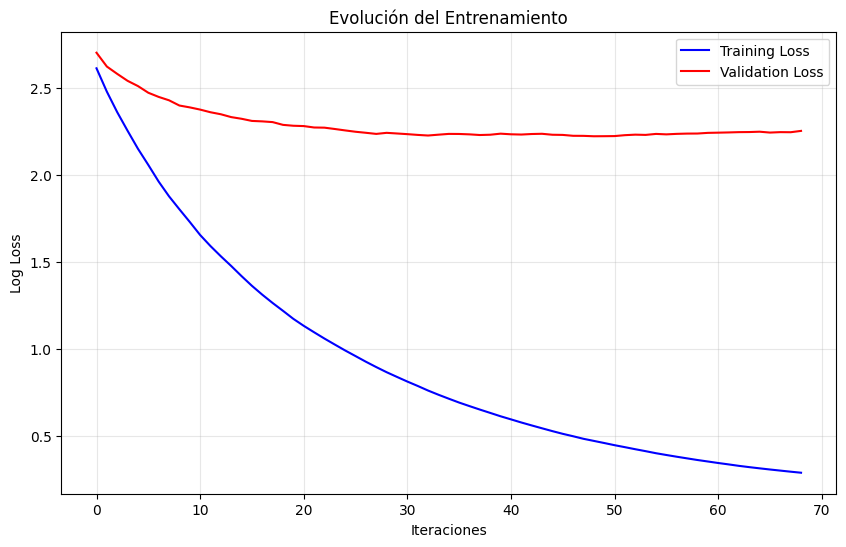

In [10]:
# Entrenamiento del modelo XGBoost mejorado
print("🚀 Entrenando modelo XGBoost mejorado...")

# Configuración del modelo
model = xgb.XGBClassifier(
    n_estimators=300,        # Más árboles
    max_depth=8,             # Más profundidad
    learning_rate=0.1,       # Tasa de aprendizaje
    subsample=0.8,           # Submuestreo
    colsample_bytree=0.8,    # Submuestreo de características
    random_state=42,
    eval_metric='mlogloss',
    early_stopping_rounds=20,
    n_jobs=-1                # Usar todos los cores
)

# Entrenamiento con validación (sintaxis corregida)
print("⏳ Iniciando entrenamiento...")
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=50  # Mostrar progreso cada 50 iteraciones
)

print("✅ Entrenamiento completado!")

# Predicciones
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Métricas
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\n📊 Resultados del modelo:")
print(f"   🎯 Precisión en entrenamiento: {train_accuracy:.4f}")
print(f"   🎯 Precisión en prueba: {test_accuracy:.4f}")
print(f"   📉 Diferencia (overfitting): {train_accuracy - test_accuracy:.4f}")

# Mostrar historial de entrenamiento si está disponible
if hasattr(model, 'evals_result_'):
    results = model.evals_result_
    train_scores = results['validation_0']['mlogloss']
    test_scores = results['validation_1']['mlogloss']
    
    print(f"\n📈 Evolución del entrenamiento:")
    print(f"   📊 Mejor iteración: {model.best_iteration}")
    print(f"   📉 Mejor score train: {min(train_scores):.4f}")
    print(f"   📉 Mejor score test: {min(test_scores):.4f}")
    
    # Opcional: Graficar evolución del entrenamiento
    plt.figure(figsize=(10, 6))
    plt.plot(train_scores, label='Training Loss', color='blue')
    plt.plot(test_scores, label='Validation Loss', color='red')
    plt.xlabel('Iteraciones')
    plt.ylabel('Log Loss')
    plt.title('Evolución del Entrenamiento')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()